In [5]:
import pandas as pd

In [6]:
# Load the dataset from the datasets folder
dataset_path = '../traintestdata/Reddit_ideations.csv'
df = pd.read_csv(dataset_path)
print(df.head())
df.info()
df.isnull().sum()
df.describe(include='all')

     User                                               Post       Label
0  user-0  ['Its not a viable option, and youll be leavin...  Supportive
1  user-1  ['It can be hard to appreciate the notion that...    Ideation
2  user-2  ['Hi, so last night i was sitting on the ledge...    Behavior
3  user-3  ['I tried to kill my self once and failed badl...     Attempt
4  user-4  ['Hi NEM3030. What sorts of things do you enjo...    Ideation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    500 non-null    object
 1   Post    500 non-null    object
 2   Label   500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


,User,Post,Label
count,500,500,500
unique,500,500,5
top,user-0,"['Its not a viable option, and youll be leavin...",Ideation
freq,1,1,171


<h3>Clean Dataset

<p> Note, since I'm using a Roberta transformer, minimal data cleaning is required <p>

In [7]:
# remove user column
df = df.drop(columns=['User'])
# remove potential duplicates
df = df.drop_duplicates(subset=['Post', 'Label'])
# remove null values
df = df.dropna()
# add a column for the processed text
df['Processed'] = df['Post']

In [8]:
import nltk
import re
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
# tokenize
df['Processed'] = df['Processed'].apply(lambda x: word_tokenize(x))
# remove any links
df['Processed'] = df['Processed'].apply(lambda x: [i for i in x if ('http' or 'www') not in i])
# join tokens back together 
df['Processed'] = df['Processed'].apply(lambda x: ' '.join(x))
# Create less confusing labels
# the idea is that each label can indicate a level of severity
# potentially useful for training
label_map = {
    'Supportive': 0,
    'Ideation': 1,
    'Indicator': 2,
    'Behavior': 3,
    'Attempt': 4
}
df['numLabel'] = df['Label'].apply(lambda x: label_map[x])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zlyon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\zlyon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zlyon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
df.head()

,Post,Label,Processed,numLabel
0,"['Its not a viable option, and youll be leavin...",Supportive,"[ 'Its not a viable option , and youll be leav...",0
1,['It can be hard to appreciate the notion that...,Ideation,[ 'It can be hard to appreciate the notion tha...,1
2,"['Hi, so last night i was sitting on the ledge...",Behavior,"[ 'Hi , so last night i was sitting on the led...",3
3,['I tried to kill my self once and failed badl...,Attempt,[ ' I tried to kill my self once and failed ba...,4
4,['Hi NEM3030. What sorts of things do you enjo...,Ideation,[ 'Hi NEM3030 . What sorts of things do you en...,1


<h3> Plot trends of the data

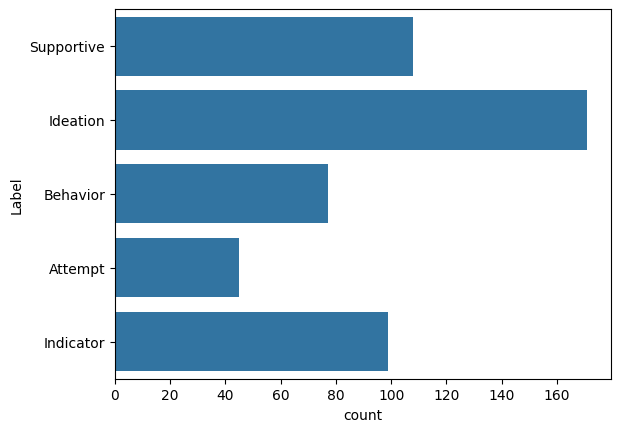

In [10]:
# show distribution of labels
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df['Label'])
plt.show()

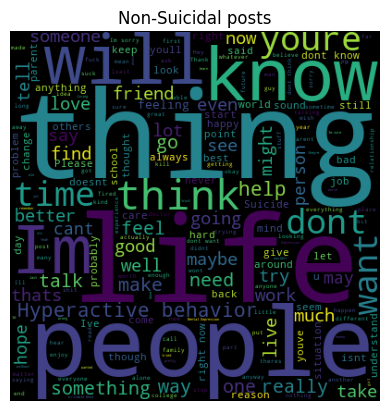

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# create a word cloud of each label
wordcloud = WordCloud(width = 400, height = 400).generate(' '.join(df[df['numLabel'] == 0]['Post']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Non-Suicidal posts')
plt.show()


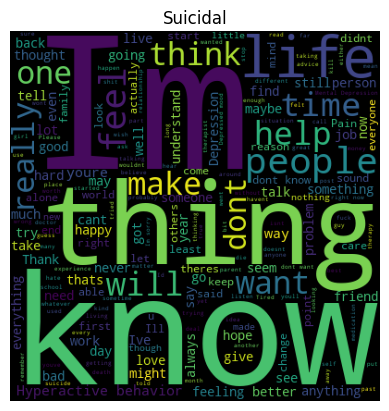

In [12]:
wordcloud = WordCloud(width = 400, height = 400).generate(' '.join(df[df['numLabel'] == 1]['Post']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Suicidal')
plt.show()

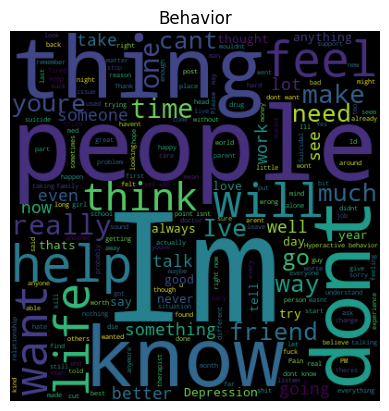

In [13]:
wordcloud = WordCloud(width = 400, height = 400).generate(' '.join(df[df['numLabel'] == 3]['Processed']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Behavior')
plt.show()

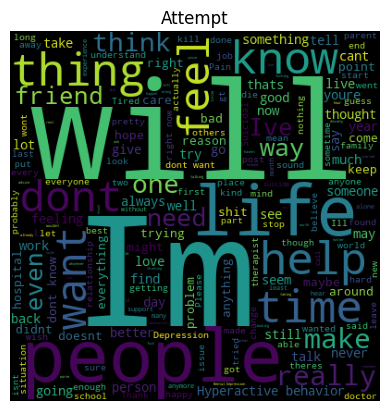

In [14]:
wordcloud = WordCloud(width = 400, height = 400).generate(' '.join(df[df['numLabel'] == 4]['Processed']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Attempt')
plt.show()

In [15]:
# Calculate the length of each post
df['Post_Length'] = df['Post'].apply(len)

# Calculate the average length
average_length = df['Post_Length'].mean()

print(f"The average length of each datapoint in the dataset is {average_length:.2f} characters.")

The average length of each datapoint in the dataset is 7218.35 characters.


In [16]:
# Calculate the average length of posts for each category
average_length_per_category = df.groupby('Label')['Post_Length'].mean()

print(average_length_per_category)

Label
Attempt       7992.222222
Behavior      8185.402597
Ideation      6388.456140
Indicator     7734.676768
Supportive    7047.148148
Name: Post_Length, dtype: float64


<p>We can see that in the posts that have a higher than 0 ideation the focus tends to be about the individual <p>
<p>This may potentially cause a problem when training the model since in regular therapy one should talk about themselves <p>
<p>Another thing to note is that I should place less emphasis on words that appear in all 4 often <p>

<h3> Synthetically Altering Dataset

<p> Since the Reddit Ideations dataset is too small I will test augmenting/altering/summarizing the data in order to create more data in the CSV file to better fine tune the model

In [17]:
'''This cell uses the T5 model to summarize the text from the dataset'''
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the T5 model and tokenizer
model_name = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Function to summarize text using T5
def summarize_text(text, max_length=50, min_length=25):
    # Preprocess the text
    preprocess_text = text.strip().replace("\n", " ")
    t5_input_text = "summarize: " + preprocess_text

    # Tokenize the input text
    tokenized_text = tokenizer.encode(t5_input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

    # Generate summary
    summary_ids = model.generate(tokenized_text, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

# Apply the summarization function to the dataset
df['Summary'] = df['Post'].apply(lambda x: summarize_text(x, max_length=50, min_length=25))

# Display the summarized text
df[['Post', 'Summary']].head()

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
# prinr first summary and label
print(df['Summary'][2])
print(df['Label'][2])

KeyError: 'Summary'

In [ ]:
# new dataframe that contains only the augmented data
augmented_df = df[['Summary', 'Label']].copy()
augmented_df.columns = ['data', 'label']
print(augmented_df.head())

KeyError: "['Summary'] not in index"

In [ ]:
import nlpaug.augmenter.word as naw
import pandas as pd

# Define augmenters
aug_synonym = naw.SynonymAug(aug_src='wordnet')
aug_back_translation = naw.BackTranslationAug(from_model_name='facebook/wmt19-en-de', to_model_name='facebook/wmt19-de-en')

# Function to augment text
def augment_text(text):
    augmented_texts = []
    # Synonym replacement
    augmented_texts.append(aug_synonym.augment(text))
    # Back translation
    augmented_texts.append(aug_back_translation.augment(text))
    return augmented_texts

# Create a new dataframe to store augmented data
augmented_data = []

# Apply augmentations to the summarized text
for index, row in df.iterrows():
    original_text = row['Summary']
    label = row['Label']
    augmented_texts = augment_text(original_text)
    for aug_text in augmented_texts:
        augmented_data.append({'Text': aug_text, 'Label': label})
# Convert the augmented data to a dataframe
augmented_df = pd.DataFrame(augmented_data)
print(augmented_df.head())
# Combine the original and augmented data
combined_df = pd.concat([df[['Summary', 'Label']].rename(columns={'Summary': 'Text'}), augmented_df])

# Ensure the dataset has around 2000 rows
if len(combined_df) < 1000:
    additional_data = combined_df.sample(1000 - len(combined_df), replace=True)
    combined_df = pd.concat([combined_df, additional_data])

# # Save the augmented dataset to a new CSV file
combined_df.to_csv('augmented_dataset.csv', index=False)

# # Display the first few rows of the augmented dataset
combined_df.head()

                                                Text       Label
0  [' this comprise a big examination for you, an...  Supportive
1  ["This is a big test for you, and you will pas...  Supportive
2  [' the voice live just now a voice. people pot...    Ideation
3  ["the voice is just a voice. people can praise...    Ideation
4  [a champion of mine posted a post on a subredd...    Behavior


,Text,Label
0,"'this is a big test for you, and youll pull th...",Supportive
1,'the voice is just a voice. people can praise ...,Ideation
2,a friend of mine posted a post on a subreddit ...,Behavior
3,'i know that feeling you got right now but the...,Attempt
4,"'nothing like losing yourself in music, escapi...",Ideation


<h3> Clean New Data

In [18]:
combined_df = pd.read_csv('augmented_dataset.csv')
combined_df.head()

,Text,Label
0,"'this is a big test for you, and youll pull th...",Supportive
1,'the voice is just a voice. people can praise ...,Ideation
2,a friend of mine posted a post on a subreddit ...,Behavior
3,'i know that feeling you got right now but the...,Attempt
4,"'nothing like losing yourself in music, escapi...",Ideation


In [40]:
import re

# Function to clean punctuation
def clean_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the cleaning function to the 'Text' column
combined_df['Text'] = combined_df['Text'].apply(clean_text)

# remove unlabelled data
combined_df = combined_df.dropna()

# Display the cleaned dataframe
print(combined_df.head())
# map labels to numbers
label_map = {
    'Supportive': 0,
    'Ideation': 1,
    'Indicator': 2,
    'Behavior': 3,
    'Attempt': 4
}
combined_df['Label'] = combined_df['Label'].apply(lambda x: label_map[x])
print(combined_df.head())

                                                Text       Label
0  this is a big test for you and youll pull thro...  Supportive
1  the voice is just a voice people can praise yo...    Ideation
2  a friend of mine posted a post on a subreddit ...    Behavior
3  i know that feeling you got right now but ther...     Attempt
4  nothing like losing yourself in music escaping...    Ideation
                                                Text  Label
0  this is a big test for you and youll pull thro...      0
1  the voice is just a voice people can praise yo...      1
2  a friend of mine posted a post on a subreddit ...      3
3  i know that feeling you got right now but ther...      4
4  nothing like losing yourself in music escaping...      1


<h3> Train Model

In [41]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=99)
# convert to hugging face dataset from pandas dataframe
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
train_dataset = train_dataset.rename_column("Label", "labels")
test_dataset = test_dataset.rename_column("Label", "labels")


In [42]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "DistilRoBERTa-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)  # num_labels=2 for binary classification

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DistilRoBERTa-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
def tokenize(batch):
    tokenized = tokenizer(batch['Text'], padding="max_length", truncation=True, max_length=256)
    tokenized['labels'] = batch['labels']
    return tokenized
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|██████████| 300/300 [00:00<00:00, 11999.73 examples/s]


In [77]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate= 2.0121101091526134e-05,               # Adjusted learning rate
    num_train_epochs=3,               # Fewer epochs to avoid overfitting
    per_device_train_batch_size=3,    # Adjust batch size based on memory
    per_device_eval_batch_size=3,
    gradient_accumulation_steps=2,    # Reduce accumulation to allow larger batch size
    weight_decay=0.05,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Use F1 for the best model metric
    greater_is_better=True
)




In [78]:
import torch
print(torch.cuda.is_available())

True


In [79]:
print(train_dataset[0])

{'labels': tensor(0), 'input_ids': tensor([    0,    65,  1437,   475,   786, 22024,    47,  5909,    95,   224,
           99,    83,   858,   222,   389,   728,   536,    38,    21, 11963,
          159,  7209,   198,    19,   127,  1441,     8,   310, 49176,  1437,
         1437,   939,  1437, 26835,   625,    45,  1236,   990,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1, 

In [80]:
from transformers import Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model.to('cuda'),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


 89%|████████▉ | 17/19 [13:21<00:00, 28.76it/s]


{'loss': 0.0, 'grad_norm': 1.9796441392827546e-06, 'learning_rate': 1.9785749406667365e-05, 'epoch': 0.05}


 89%|████████▉ | 17/19 [13:22<00:00, 28.76it/s] 


{'loss': 0.0, 'grad_norm': 0.00024449845659546554, 'learning_rate': 1.9450397721808597e-05, 'epoch': 0.1}


 89%|████████▉ | 17/19 [13:22<00:00, 28.76it/s] 


{'loss': 0.0, 'grad_norm': 0.007423459552228451, 'learning_rate': 1.9115046036949825e-05, 'epoch': 0.15}


 89%|████████▉ | 17/19 [13:23<00:00, 28.76it/s] 


{'loss': 0.0148, 'grad_norm': 5.502413387148408e-07, 'learning_rate': 1.877969435209106e-05, 'epoch': 0.2}


 89%|████████▉ | 17/19 [13:24<00:00, 28.76it/s] 

{'loss': 0.0, 'grad_norm': 0.002876048209145665, 'learning_rate': 1.8444342667232288e-05, 'epoch': 0.25}



 89%|████████▉ | 17/19 [13:24<00:00, 28.76it/s] 


{'loss': 0.2702, 'grad_norm': 0.06222134083509445, 'learning_rate': 1.810899098237352e-05, 'epoch': 0.3}


 89%|████████▉ | 17/19 [13:25<00:00, 28.76it/s] 


{'loss': 0.0058, 'grad_norm': 4.2842466996262374e-07, 'learning_rate': 1.777363929751475e-05, 'epoch': 0.35}


 89%|████████▉ | 17/19 [13:26<00:00, 28.76it/s] 


{'loss': 0.0, 'grad_norm': 0.021448582410812378, 'learning_rate': 1.7438287612655983e-05, 'epoch': 0.4}


 89%|████████▉ | 17/19 [13:27<00:00, 28.76it/s] 


{'loss': 0.177, 'grad_norm': 2.2551244001078885e-06, 'learning_rate': 1.7102935927797214e-05, 'epoch': 0.45}


 89%|████████▉ | 17/19 [13:27<00:00, 28.76it/s] 


{'loss': 0.0096, 'grad_norm': 0.00018727296264842153, 'learning_rate': 1.6767584242938446e-05, 'epoch': 0.5}


 89%|████████▉ | 17/19 [13:28<00:00, 28.76it/s]  


{'loss': 0.0816, 'grad_norm': 5.593639798462391e-06, 'learning_rate': 1.6432232558079674e-05, 'epoch': 0.55}


 89%|████████▉ | 17/19 [13:29<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 2.4720568035263568e-05, 'learning_rate': 1.609688087322091e-05, 'epoch': 0.6}


 89%|████████▉ | 17/19 [13:29<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 2.505237171135377e-05, 'learning_rate': 1.5761529188362137e-05, 'epoch': 0.65}


 89%|████████▉ | 17/19 [13:30<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.8511938151277718e-06, 'learning_rate': 1.542617750350337e-05, 'epoch': 0.7}


 89%|████████▉ | 17/19 [13:31<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 2.832168320310302e-05, 'learning_rate': 1.50908258186446e-05, 'epoch': 0.75}


 89%|████████▉ | 17/19 [13:31<00:00, 28.76it/s]  

{'loss': 0.0008, 'grad_norm': 0.001142115448601544, 'learning_rate': 1.475547413378583e-05, 'epoch': 0.8}



 89%|████████▉ | 17/19 [13:32<00:00, 28.76it/s]  


{'loss': 0.297, 'grad_norm': 1.9369150322745554e-05, 'learning_rate': 1.4420122448927063e-05, 'epoch': 0.85}


 89%|████████▉ | 17/19 [13:33<00:00, 28.76it/s]  


{'loss': 0.1, 'grad_norm': 1.073859220923623e-05, 'learning_rate': 1.4084770764068293e-05, 'epoch': 0.9}


 89%|████████▉ | 17/19 [13:33<00:00, 28.76it/s]  


{'loss': 0.0298, 'grad_norm': 348.12127685546875, 'learning_rate': 1.3749419079209525e-05, 'epoch': 0.95}


 89%|████████▉ | 17/19 [13:34<00:00, 28.76it/s]  

{'loss': 0.1404, 'grad_norm': 0.0007838812307454646, 'learning_rate': 1.3414067394350755e-05, 'epoch': 1.0}












                                           
                                                 
 89%|████████▉ | 17/19 [13:35<00:00, 28.76it/s]


{'eval_loss': 2.068751335144043, 'eval_accuracy': 0.8266666666666667, 'eval_f1': 0.8037962125955161, 'eval_precision': 0.7922741178840095, 'eval_recall': 0.8272631578947369, 'eval_runtime': 0.8274, 'eval_samples_per_second': 362.575, 'eval_steps_per_second': 120.858, 'epoch': 1.0}



 89%|████████▉ | 17/19 [13:38<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.2982409316464327e-05, 'learning_rate': 1.3078715709491988e-05, 'epoch': 1.05}


 89%|████████▉ | 17/19 [13:39<00:00, 28.76it/s]  


{'loss': 0.0018, 'grad_norm': 73.5866928100586, 'learning_rate': 1.2743364024633218e-05, 'epoch': 1.1}


 89%|████████▉ | 17/19 [13:39<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.7054417185136117e-06, 'learning_rate': 1.240801233977445e-05, 'epoch': 1.15}


 89%|████████▉ | 17/19 [13:40<00:00, 28.76it/s]  


{'loss': 0.0003, 'grad_norm': 0.0030500111170113087, 'learning_rate': 1.207266065491568e-05, 'epoch': 1.2}


 89%|████████▉ | 17/19 [13:41<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.1234113799218903e-06, 'learning_rate': 1.1737308970056913e-05, 'epoch': 1.25}


 89%|████████▉ | 17/19 [13:41<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.4778285731154028e-05, 'learning_rate': 1.1401957285198142e-05, 'epoch': 1.3}


 89%|████████▉ | 17/19 [13:42<00:00, 28.76it/s]  


{'loss': 0.0561, 'grad_norm': 1.1826620720967185e-05, 'learning_rate': 1.1066605600339374e-05, 'epoch': 1.35}


 89%|████████▉ | 17/19 [13:43<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 7.782896886965318e-07, 'learning_rate': 1.0731253915480604e-05, 'epoch': 1.4}


 89%|████████▉ | 17/19 [13:43<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.5551707974736928e-06, 'learning_rate': 1.0395902230621837e-05, 'epoch': 1.45}


 89%|████████▉ | 17/19 [13:44<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.8651804793989868e-06, 'learning_rate': 1.0060550545763067e-05, 'epoch': 1.5}


 89%|████████▉ | 17/19 [13:45<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 4.0843435272108763e-05, 'learning_rate': 9.725198860904298e-06, 'epoch': 1.55}


 89%|████████▉ | 17/19 [13:45<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 7.458592676812259e-07, 'learning_rate': 9.38984717604553e-06, 'epoch': 1.6}


 89%|████████▉ | 17/19 [13:46<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 6.70376437028608e-07, 'learning_rate': 9.05449549118676e-06, 'epoch': 1.65}


 89%|████████▉ | 17/19 [13:47<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 3.449656651355326e-05, 'learning_rate': 8.719143806327991e-06, 'epoch': 1.7}


 89%|████████▉ | 17/19 [13:47<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 0.00012307876022532582, 'learning_rate': 8.383792121469223e-06, 'epoch': 1.75}


 89%|████████▉ | 17/19 [13:48<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 5.423183324637648e-07, 'learning_rate': 8.048440436610455e-06, 'epoch': 1.8}


 89%|████████▉ | 17/19 [13:49<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 2.1359794573072577e-06, 'learning_rate': 7.713088751751684e-06, 'epoch': 1.85}


 89%|████████▉ | 17/19 [13:49<00:00, 28.76it/s]  


{'loss': 0.0534, 'grad_norm': 1.3142414445610484e-06, 'learning_rate': 7.377737066892915e-06, 'epoch': 1.9}


 89%|████████▉ | 17/19 [13:50<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 4.385334614198655e-05, 'learning_rate': 7.042385382034147e-06, 'epoch': 1.95}


 89%|████████▉ | 17/19 [13:51<00:00, 28.76it/s]  

{'loss': 0.0001, 'grad_norm': 5.661059390149603e-07, 'learning_rate': 6.707033697175377e-06, 'epoch': 2.0}












                                           
                                                 
 89%|████████▉ | 17/19 [13:51<00:00, 28.76it/s]


{'eval_loss': 1.9656901359558105, 'eval_accuracy': 0.8366666666666667, 'eval_f1': 0.8046975078328721, 'eval_precision': 0.7971775040592263, 'eval_recall': 0.8254152046783625, 'eval_runtime': 0.829, 'eval_samples_per_second': 361.896, 'eval_steps_per_second': 120.632, 'epoch': 2.0}



 89%|████████▉ | 17/19 [13:54<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.2788512322003953e-05, 'learning_rate': 6.371682012316609e-06, 'epoch': 2.05}


 89%|████████▉ | 17/19 [13:55<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 3.1656049941375386e-06, 'learning_rate': 6.03633032745784e-06, 'epoch': 2.1}


 89%|████████▉ | 17/19 [13:56<00:00, 28.76it/s]  


{'loss': 0.0404, 'grad_norm': 1.7391166693414561e-06, 'learning_rate': 5.700978642599071e-06, 'epoch': 2.15}


 89%|████████▉ | 17/19 [13:56<00:00, 28.76it/s]  


{'loss': 0.0044, 'grad_norm': 1.0746138059403165e-06, 'learning_rate': 5.365626957740302e-06, 'epoch': 2.2}


 89%|████████▉ | 17/19 [13:57<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 2.5817196274147136e-06, 'learning_rate': 5.0302752728815335e-06, 'epoch': 2.25}


 89%|████████▉ | 17/19 [13:58<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.1228211178604397e-06, 'learning_rate': 4.694923588022765e-06, 'epoch': 2.3}


 89%|████████▉ | 17/19 [13:58<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 4.693072241934715e-07, 'learning_rate': 4.359571903163996e-06, 'epoch': 2.35}


 89%|████████▉ | 17/19 [13:59<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 5.192298999645573e-07, 'learning_rate': 4.024220218305227e-06, 'epoch': 2.4}


 89%|████████▉ | 17/19 [14:00<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.5845558664295822e-05, 'learning_rate': 3.6888685334464576e-06, 'epoch': 2.45}


 89%|████████▉ | 17/19 [14:00<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 8.88388001385465e-07, 'learning_rate': 3.3535168485876887e-06, 'epoch': 2.5}


 89%|████████▉ | 17/19 [14:01<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 7.394884505629307e-06, 'learning_rate': 3.01816516372892e-06, 'epoch': 2.55}


 89%|████████▉ | 17/19 [14:02<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 4.939629434375092e-07, 'learning_rate': 2.682813478870151e-06, 'epoch': 2.6}


 89%|████████▉ | 17/19 [14:02<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.5371049812529236e-05, 'learning_rate': 2.3474617940113825e-06, 'epoch': 2.65}


 89%|████████▉ | 17/19 [14:03<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 0.0014606998302042484, 'learning_rate': 2.0121101091526136e-06, 'epoch': 2.7}


 89%|████████▉ | 17/19 [14:04<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 3.5167289524906664e-07, 'learning_rate': 1.6767584242938443e-06, 'epoch': 2.75}


 89%|████████▉ | 17/19 [14:04<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 2.619306087581208e-06, 'learning_rate': 1.3414067394350755e-06, 'epoch': 2.8}


 89%|████████▉ | 17/19 [14:05<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.883697768789716e-05, 'learning_rate': 1.0060550545763068e-06, 'epoch': 2.85}


 89%|████████▉ | 17/19 [14:06<00:00, 28.76it/s]  

{'loss': 0.0, 'grad_norm': 1.576229692545894e-06, 'learning_rate': 6.707033697175377e-07, 'epoch': 2.9}



 89%|████████▉ | 17/19 [14:06<00:00, 28.76it/s]  


{'loss': 0.0, 'grad_norm': 1.0792323337227572e-06, 'learning_rate': 3.3535168485876887e-07, 'epoch': 2.95}


 89%|████████▉ | 17/19 [14:07<00:00, 28.76it/s]  

{'loss': 0.0, 'grad_norm': 2.9484751848940505e-06, 'learning_rate': 0.0, 'epoch': 3.0}














                                           
                                                 
 89%|████████▉ | 17/19 [14:12<00:00, 28.76it/s]


{'eval_loss': 1.864950180053711, 'eval_accuracy': 0.8333333333333334, 'eval_f1': 0.8154561347548761, 'eval_precision': 0.8072746094485226, 'eval_recall': 0.8328187134502925, 'eval_runtime': 1.0607, 'eval_samples_per_second': 282.827, 'eval_steps_per_second': 94.276, 'epoch': 3.0}



100%|██████████| 600/600 [00:54<00:00, 11.11it/s]

{'train_runtime': 54.0188, 'train_samples_per_second': 66.644, 'train_steps_per_second': 11.107, 'train_loss': 0.02139492662315328, 'epoch': 3.0}


TrainOutput(global_step=600, training_loss=0.02139492662315328, metrics={'train_runtime': 54.0188, 'train_samples_per_second': 66.644, 'train_steps_per_second': 11.107, 'total_flos': 238454074368000.0, 'train_loss': 0.02139492662315328, 'epoch': 3.0})

In [83]:
import optuna
from transformers import Trainer, TrainingArguments

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 5)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir="./logs",
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model.to('cuda'),
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()

    # Return the evaluation metric (e.g., accuracy, loss)
    return eval_result["eval_loss"]

# Create a study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-11-18 17:26:33,442] A new study created in memory with name: no-name-4046f8ff-3000-43b4-a79f-7df34a7c182f
 25%|██▌       | 38/152 [00:09<00:22,  5.00it/s]






                                         
                                                 
 25%|██▌       | 38/152 [00:09<00:22,  5.00it/s]


{'eval_loss': 1.6166324615478516, 'eval_runtime': 0.6701, 'eval_samples_per_second': 447.681, 'eval_steps_per_second': 14.923, 'epoch': 1.0}


 50%|█████     | 76/152 [00:18<00:15,  5.06it/s]






                                         
                                                 
 50%|█████     | 76/152 [00:19<00:15,  5.06it/s]


{'eval_loss': 1.7346805334091187, 'eval_runtime': 0.6626, 'eval_samples_per_second': 452.781, 'eval_steps_per_second': 15.093, 'epoch': 2.0}


 75%|███████▌  | 114/152 [00:27<00:07,  5.03it/s]






                                         
                                                 
 75%|███████▌  | 114/152 [00:28<00:07,  5.03it/s]


{'eval_loss': 1.5312491655349731, 'eval_runtime': 0.6646, 'eval_samples_per_second': 451.366, 'eval_steps_per_second': 15.046, 'epoch': 3.0}


100%|██████████| 152/152 [00:36<00:00,  5.04it/s]







                                         
                                                 
100%|██████████| 152/152 [00:40<00:00,  5.04it/s]

100%|██████████| 152/152 [00:40<00:00,  3.79it/s]


{'eval_loss': 1.529464602470398, 'eval_runtime': 0.8471, 'eval_samples_per_second': 354.129, 'eval_steps_per_second': 11.804, 'epoch': 4.0}
{'train_runtime': 40.0559, 'train_samples_per_second': 119.832, 'train_steps_per_second': 3.795, 'train_loss': 0.004942616349772403, 'epoch': 4.0}


100%|██████████| 10/10 [00:00<00:00, 15.19it/s]
[I 2024-11-18 17:27:14,523] Trial 0 finished with value: 1.529464602470398 and parameters: {'learning_rate': 1.2340226723032872e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 0 with value: 1.529464602470398.
 50%|█████     | 150/300 [00:10<00:10, 13.77it/s]








                                         
                                                 
 51%|█████     | 152/300 [00:11<00:26,  5.56it/s]

{'eval_loss': 1.5830817222595215, 'eval_runtime': 0.7151, 'eval_samples_per_second': 419.525, 'eval_steps_per_second': 53.14, 'epoch': 1.0}


100%|██████████| 300/300 [00:22<00:00, 13.75it/s]








                                         
                                                 
100%|██████████| 300/300 [00:25<00:00, 13.75it/s]

100%|██████████| 300/300 [00:25<00:00, 11.94it/s]


{'eval_loss': 1.6412979364395142, 'eval_runtime': 0.7284, 'eval_samples_per_second': 411.847, 'eval_steps_per_second': 52.167, 'epoch': 2.0}
{'train_runtime': 25.1179, 'train_samples_per_second': 95.549, 'train_steps_per_second': 11.944, 'train_loss': 0.0008933838208516439, 'epoch': 2.0}


100%|██████████| 38/38 [00:00<00:00, 52.89it/s]
[I 2024-11-18 17:27:40,659] Trial 1 finished with value: 1.6412979364395142 and parameters: {'learning_rate': 2.17230180655461e-05, 'batch_size': 8, 'num_train_epochs': 2}. Best is trial 0 with value: 1.529464602470398.
100%|██████████| 38/38 [00:08<00:00,  5.02it/s]







                                         
                                                 
100%|██████████| 38/38 [00:12<00:00,  5.02it/s]

100%|██████████| 38/38 [00:12<00:00,  2.93it/s]  


{'eval_loss': 1.591904878616333, 'eval_runtime': 0.8121, 'eval_samples_per_second': 369.424, 'eval_steps_per_second': 12.314, 'epoch': 1.0}
{'train_runtime': 12.966, 'train_samples_per_second': 92.55, 'train_steps_per_second': 2.931, 'train_loss': 8.421038967897307e-08, 'epoch': 1.0}


100%|██████████| 10/10 [00:00<00:00, 14.32it/s]
[I 2024-11-18 17:27:54,608] Trial 2 finished with value: 1.591904878616333 and parameters: {'learning_rate': 1.6352686952624547e-05, 'batch_size': 32, 'num_train_epochs': 1}. Best is trial 0 with value: 1.529464602470398.
 25%|██▌       | 150/600 [00:10<00:32, 13.76it/s]








                                         
                                                 
 25%|██▌       | 152/600 [00:11<01:21,  5.53it/s]

{'eval_loss': 1.6617565155029297, 'eval_runtime': 0.7189, 'eval_samples_per_second': 417.319, 'eval_steps_per_second': 52.86, 'epoch': 1.0}


 50%|█████     | 300/600 [00:22<00:21, 13.78it/s]








                                         
                                                 
 50%|█████     | 302/600 [00:23<00:53,  5.52it/s]

{'eval_loss': 1.6893856525421143, 'eval_runtime': 0.7223, 'eval_samples_per_second': 415.357, 'eval_steps_per_second': 52.612, 'epoch': 2.0}


 75%|███████▌  | 450/600 [00:34<00:10, 13.75it/s]








                                         
                                                 
 75%|███████▌  | 452/600 [00:35<00:26,  5.51it/s]

{'eval_loss': 1.705636978149414, 'eval_runtime': 0.7224, 'eval_samples_per_second': 415.304, 'eval_steps_per_second': 52.605, 'epoch': 3.0}


 83%|████████▎ | 500/600 [00:38<00:07, 13.71it/s]

{'loss': 0.0035, 'grad_norm': 1.5989310213626595e-06, 'learning_rate': 2.908096548049324e-06, 'epoch': 3.33}


100%|██████████| 600/600 [00:47<00:00, 13.76it/s]









                                         
                                                 
100%|██████████| 600/600 [00:50<00:00, 13.76it/s]

100%|██████████| 600/600 [00:50<00:00, 11.91it/s]


{'eval_loss': 1.618967890739441, 'eval_runtime': 0.8871, 'eval_samples_per_second': 338.194, 'eval_steps_per_second': 42.838, 'epoch': 4.0}
{'train_runtime': 50.3662, 'train_samples_per_second': 95.302, 'train_steps_per_second': 11.913, 'train_loss': 0.0028792332768352935, 'epoch': 4.0}


100%|██████████| 38/38 [00:00<00:00, 51.25it/s]
[I 2024-11-18 17:28:46,028] Trial 3 finished with value: 1.618967890739441 and parameters: {'learning_rate': 1.7448579288295944e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 0 with value: 1.529464602470398.
 33%|███▎      | 150/450 [00:10<00:21, 13.71it/s]








                                         
                                                 
 34%|███▍      | 152/450 [00:11<00:54,  5.49it/s]

{'eval_loss': 2.4061145782470703, 'eval_runtime': 0.7263, 'eval_samples_per_second': 413.031, 'eval_steps_per_second': 52.317, 'epoch': 1.0}


 67%|██████▋   | 300/450 [00:22<00:10, 13.71it/s]








                                         
                                                 
 67%|██████▋   | 302/450 [00:23<00:26,  5.51it/s]

{'eval_loss': 1.8148307800292969, 'eval_runtime': 0.7233, 'eval_samples_per_second': 414.777, 'eval_steps_per_second': 52.538, 'epoch': 2.0}


100%|██████████| 450/450 [00:34<00:00, 13.72it/s]









                                         
                                                 
100%|██████████| 450/450 [00:37<00:00, 13.72it/s]

100%|██████████| 450/450 [00:37<00:00, 12.13it/s]


{'eval_loss': 1.727847933769226, 'eval_runtime': 0.8788, 'eval_samples_per_second': 341.365, 'eval_steps_per_second': 43.24, 'epoch': 3.0}
{'train_runtime': 37.104, 'train_samples_per_second': 97.025, 'train_steps_per_second': 12.128, 'train_loss': 0.007290217611524794, 'epoch': 3.0}


100%|██████████| 38/38 [00:00<00:00, 50.71it/s]
[I 2024-11-18 17:29:24,162] Trial 4 finished with value: 1.727847933769226 and parameters: {'learning_rate': 2.1283508769671923e-05, 'batch_size': 8, 'num_train_epochs': 3}. Best is trial 0 with value: 1.529464602470398.
 50%|█████     | 38/76 [00:08<00:07,  5.03it/s]






                                         
                                                 
 50%|█████     | 38/76 [00:09<00:07,  5.03it/s]


{'eval_loss': 1.7845059633255005, 'eval_runtime': 0.6636, 'eval_samples_per_second': 452.074, 'eval_steps_per_second': 15.069, 'epoch': 1.0}


100%|██████████| 76/76 [00:18<00:00,  5.01it/s]






                                         
                                                 
100%|██████████| 76/76 [00:20<00:00,  5.01it/s]

100%|██████████| 76/76 [00:20<00:00,  3.71it/s]  


{'eval_loss': 1.7600704431533813, 'eval_runtime': 0.6596, 'eval_samples_per_second': 454.809, 'eval_steps_per_second': 15.16, 'epoch': 2.0}
{'train_runtime': 20.4587, 'train_samples_per_second': 117.31, 'train_steps_per_second': 3.715, 'train_loss': 0.005986922273510381, 'epoch': 2.0}


100%|██████████| 10/10 [00:00<00:00, 15.03it/s]
[I 2024-11-18 17:29:45,590] Trial 5 finished with value: 1.7600704431533813 and parameters: {'learning_rate': 1.7568068770791764e-05, 'batch_size': 32, 'num_train_epochs': 2}. Best is trial 0 with value: 1.529464602470398.
 25%|██▌       | 38/152 [00:08<00:22,  5.13it/s]






                                         
                                                 
 25%|██▌       | 38/152 [00:09<00:22,  5.13it/s]


{'eval_loss': 1.635101556777954, 'eval_runtime': 0.7096, 'eval_samples_per_second': 422.758, 'eval_steps_per_second': 14.092, 'epoch': 1.0}


 50%|█████     | 76/152 [00:18<00:14,  5.09it/s]






                                         
                                                 
 50%|█████     | 76/152 [00:18<00:14,  5.09it/s]


{'eval_loss': 1.7233587503433228, 'eval_runtime': 0.65, 'eval_samples_per_second': 461.561, 'eval_steps_per_second': 15.385, 'epoch': 2.0}


 75%|███████▌  | 114/152 [00:27<00:07,  5.00it/s]






                                         
                                                 
 75%|███████▌  | 114/152 [00:28<00:07,  5.00it/s]


{'eval_loss': 1.7153100967407227, 'eval_runtime': 0.654, 'eval_samples_per_second': 458.732, 'eval_steps_per_second': 15.291, 'epoch': 3.0}


100%|██████████| 152/152 [00:36<00:00,  4.98it/s]






                                         
                                                 
100%|██████████| 152/152 [00:39<00:00,  4.98it/s]

100%|██████████| 152/152 [00:39<00:00,  3.87it/s]


{'eval_loss': 1.7090612649917603, 'eval_runtime': 0.6357, 'eval_samples_per_second': 471.954, 'eval_steps_per_second': 15.732, 'epoch': 4.0}
{'train_runtime': 39.2647, 'train_samples_per_second': 122.247, 'train_steps_per_second': 3.871, 'train_loss': 0.0021082607931212373, 'epoch': 4.0}


100%|██████████| 10/10 [00:00<00:00, 15.55it/s]
[I 2024-11-18 17:30:25,795] Trial 6 finished with value: 1.7090612649917603 and parameters: {'learning_rate': 1.0454135614475724e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 0 with value: 1.529464602470398.
 33%|███▎      | 150/450 [00:10<00:21, 14.02it/s]








                                         
                                                 
 34%|███▍      | 152/450 [00:11<00:54,  5.43it/s]

{'eval_loss': 1.7224400043487549, 'eval_runtime': 0.744, 'eval_samples_per_second': 403.229, 'eval_steps_per_second': 51.076, 'epoch': 1.0}


 67%|██████▋   | 300/450 [00:22<00:10, 13.99it/s]








                                         
                                                 
 67%|██████▋   | 302/450 [00:23<00:26,  5.65it/s]

{'eval_loss': 1.7074694633483887, 'eval_runtime': 0.7068, 'eval_samples_per_second': 424.423, 'eval_steps_per_second': 53.76, 'epoch': 2.0}


100%|██████████| 450/450 [00:33<00:00, 14.24it/s]









                                         
                                                 
100%|██████████| 450/450 [00:36<00:00, 14.24it/s]

100%|██████████| 450/450 [00:36<00:00, 12.31it/s]


{'eval_loss': 1.7096589803695679, 'eval_runtime': 0.8141, 'eval_samples_per_second': 368.514, 'eval_steps_per_second': 46.679, 'epoch': 3.0}
{'train_runtime': 36.5551, 'train_samples_per_second': 98.481, 'train_steps_per_second': 12.31, 'train_loss': 1.2640982297145658e-06, 'epoch': 3.0}


100%|██████████| 38/38 [00:00<00:00, 55.76it/s]
[I 2024-11-18 17:31:03,324] Trial 7 finished with value: 1.7096589803695679 and parameters: {'learning_rate': 1.1991122057231732e-05, 'batch_size': 8, 'num_train_epochs': 3}. Best is trial 0 with value: 1.529464602470398.
100%|██████████| 38/38 [00:08<00:00,  5.26it/s]







                                         
                                                 
100%|██████████| 38/38 [00:12<00:00,  5.26it/s]

100%|██████████| 38/38 [00:12<00:00,  3.06it/s]  


{'eval_loss': 2.5380804538726807, 'eval_runtime': 0.8288, 'eval_samples_per_second': 361.962, 'eval_steps_per_second': 12.065, 'epoch': 1.0}
{'train_runtime': 12.411, 'train_samples_per_second': 96.688, 'train_steps_per_second': 3.062, 'train_loss': 0.0008280438027883831, 'epoch': 1.0}


100%|██████████| 10/10 [00:00<00:00, 15.88it/s]
[I 2024-11-18 17:31:16,668] Trial 8 finished with value: 2.5380804538726807 and parameters: {'learning_rate': 4.332240848037644e-05, 'batch_size': 32, 'num_train_epochs': 1}. Best is trial 0 with value: 1.529464602470398.
 25%|██▌       | 150/600 [00:10<00:33, 13.32it/s]








                                         
                                                 
 25%|██▌       | 152/600 [00:11<01:20,  5.59it/s]

{'eval_loss': 3.133169412612915, 'eval_runtime': 0.7032, 'eval_samples_per_second': 426.593, 'eval_steps_per_second': 54.035, 'epoch': 1.0}


 50%|█████     | 300/600 [00:22<00:23, 13.02it/s]








                                         
                                                 
 50%|█████     | 302/600 [00:23<00:57,  5.21it/s]

{'eval_loss': 2.0609679222106934, 'eval_runtime': 0.7514, 'eval_samples_per_second': 399.241, 'eval_steps_per_second': 50.571, 'epoch': 2.0}


 75%|███████▌  | 450/600 [00:34<00:10, 13.86it/s]








                                         
                                                 
 75%|███████▌  | 452/600 [00:35<00:26,  5.57it/s]

{'eval_loss': 1.9840128421783447, 'eval_runtime': 0.719, 'eval_samples_per_second': 417.268, 'eval_steps_per_second': 52.854, 'epoch': 3.0}


 83%|████████▎ | 500/600 [00:38<00:07, 13.68it/s]

{'loss': 0.0651, 'grad_norm': 2.2724150028352597e-07, 'learning_rate': 6.406841641432965e-06, 'epoch': 3.33}


100%|██████████| 600/600 [00:48<00:00, 14.43it/s]









                                         
                                                 
100%|██████████| 600/600 [00:51<00:00, 14.43it/s]

100%|██████████| 600/600 [00:51<00:00, 11.61it/s]


{'eval_loss': 1.562716007232666, 'eval_runtime': 0.9064, 'eval_samples_per_second': 330.982, 'eval_steps_per_second': 41.924, 'epoch': 4.0}
{'train_runtime': 51.6644, 'train_samples_per_second': 92.907, 'train_steps_per_second': 11.613, 'train_loss': 0.05428526344553878, 'epoch': 4.0}


100%|██████████| 38/38 [00:00<00:00, 55.91it/s]
[I 2024-11-18 17:32:09,319] Trial 9 finished with value: 1.562716007232666 and parameters: {'learning_rate': 3.844104984859779e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 0 with value: 1.529464602470398.
 20%|██        | 75/375 [00:09<00:35,  8.34it/s]






                                         
                                                 
 20%|██        | 76/375 [00:10<01:34,  3.17it/s]

{'eval_loss': 2.401878833770752, 'eval_runtime': 0.6533, 'eval_samples_per_second': 459.235, 'eval_steps_per_second': 29.085, 'epoch': 1.0}


 40%|████      | 150/375 [00:19<00:26,  8.35it/s]






                                         
                                                 
 40%|████      | 151/375 [00:19<01:10,  3.16it/s]

{'eval_loss': 2.2503466606140137, 'eval_runtime': 0.6553, 'eval_samples_per_second': 457.834, 'eval_steps_per_second': 28.996, 'epoch': 2.0}


 60%|██████    | 225/375 [00:29<00:18,  8.31it/s]






                                         
                                                 
 60%|██████    | 226/375 [00:29<00:47,  3.16it/s]

{'eval_loss': 1.7096531391143799, 'eval_runtime': 0.6541, 'eval_samples_per_second': 458.616, 'eval_steps_per_second': 29.046, 'epoch': 3.0}


 80%|████████  | 300/375 [00:38<00:09,  7.87it/s]







                                         
                                                 
 80%|████████  | 301/375 [00:39<00:24,  3.03it/s]

{'eval_loss': 1.8886362314224243, 'eval_runtime': 0.6856, 'eval_samples_per_second': 437.574, 'eval_steps_per_second': 27.713, 'epoch': 4.0}


100%|██████████| 375/375 [00:48<00:00,  8.32it/s]








                                         
                                                 
100%|██████████| 375/375 [00:51<00:00,  8.32it/s]

100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


{'eval_loss': 1.8428480625152588, 'eval_runtime': 0.821, 'eval_samples_per_second': 365.4, 'eval_steps_per_second': 23.142, 'epoch': 5.0}
{'train_runtime': 51.4706, 'train_samples_per_second': 116.571, 'train_steps_per_second': 7.286, 'train_loss': 0.011750420888264975, 'epoch': 5.0}


100%|██████████| 19/19 [00:00<00:00, 28.14it/s]
[I 2024-11-18 17:33:01,754] Trial 10 finished with value: 1.8428480625152588 and parameters: {'learning_rate': 3.155139002567068e-05, 'batch_size': 16, 'num_train_epochs': 5}. Best is trial 0 with value: 1.529464602470398.
 20%|██        | 75/375 [00:09<00:38,  7.89it/s]







                                         
                                                 
 20%|██        | 76/375 [00:10<01:39,  3.00it/s]

{'eval_loss': 2.823676109313965, 'eval_runtime': 0.6776, 'eval_samples_per_second': 442.76, 'eval_steps_per_second': 28.041, 'epoch': 1.0}


 40%|████      | 150/375 [00:19<00:27,  8.21it/s]







                                         
                                                 
 40%|████      | 151/375 [00:20<01:13,  3.06it/s]

{'eval_loss': 1.661454439163208, 'eval_runtime': 0.6866, 'eval_samples_per_second': 436.947, 'eval_steps_per_second': 27.673, 'epoch': 2.0}


 60%|██████    | 225/375 [00:29<00:19,  7.51it/s]







                                         
                                                 
 60%|██████    | 226/375 [00:30<00:52,  2.86it/s]

{'eval_loss': 1.8528022766113281, 'eval_runtime': 0.7232, 'eval_samples_per_second': 414.818, 'eval_steps_per_second': 26.272, 'epoch': 3.0}


 80%|████████  | 300/375 [00:40<00:10,  7.30it/s]







                                         
                                                 
 80%|████████  | 301/375 [00:41<00:25,  2.89it/s]

{'eval_loss': 1.6813559532165527, 'eval_runtime': 0.7033, 'eval_samples_per_second': 426.589, 'eval_steps_per_second': 27.017, 'epoch': 4.0}


100%|██████████| 375/375 [00:50<00:00,  8.15it/s]







                                         
                                                 
100%|██████████| 375/375 [00:53<00:00,  8.15it/s]

100%|██████████| 375/375 [00:53<00:00,  7.07it/s]


{'eval_loss': 1.276793360710144, 'eval_runtime': 0.7131, 'eval_samples_per_second': 420.718, 'eval_steps_per_second': 26.645, 'epoch': 5.0}
{'train_runtime': 53.0688, 'train_samples_per_second': 113.061, 'train_steps_per_second': 7.066, 'train_loss': 0.023944315592447918, 'epoch': 5.0}


100%|██████████| 19/19 [00:00<00:00, 26.55it/s]
[I 2024-11-18 17:33:55,825] Trial 11 finished with value: 1.276793360710144 and parameters: {'learning_rate': 3.320973093306e-05, 'batch_size': 16, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 75/375 [00:09<00:40,  7.35it/s]







                                         
                                                 
 20%|██        | 76/375 [00:10<01:41,  2.94it/s]

{'eval_loss': 1.4258439540863037, 'eval_runtime': 0.6904, 'eval_samples_per_second': 434.509, 'eval_steps_per_second': 27.519, 'epoch': 1.0}


 40%|████      | 150/375 [00:20<00:27,  8.29it/s]






                                         
                                                 
 40%|████      | 151/375 [00:21<01:12,  3.10it/s]

{'eval_loss': 1.6487504243850708, 'eval_runtime': 0.6603, 'eval_samples_per_second': 454.342, 'eval_steps_per_second': 28.775, 'epoch': 2.0}


 60%|██████    | 225/375 [00:31<00:19,  7.84it/s]







                                         
                                                 
 60%|██████    | 226/375 [00:31<00:50,  2.93it/s]

{'eval_loss': 2.4022347927093506, 'eval_runtime': 0.7198, 'eval_samples_per_second': 416.811, 'eval_steps_per_second': 26.398, 'epoch': 3.0}


 80%|████████  | 300/375 [00:41<00:09,  7.71it/s]







                                         
                                                 
 80%|████████  | 301/375 [00:42<00:24,  3.05it/s]

{'eval_loss': 1.6913129091262817, 'eval_runtime': 0.6697, 'eval_samples_per_second': 447.958, 'eval_steps_per_second': 28.371, 'epoch': 4.0}


100%|██████████| 375/375 [00:51<00:00,  8.17it/s]








                                         
                                                 
100%|██████████| 375/375 [00:53<00:00,  8.17it/s]

100%|██████████| 375/375 [00:54<00:00,  6.94it/s]


{'eval_loss': 1.6480646133422852, 'eval_runtime': 0.7952, 'eval_samples_per_second': 377.245, 'eval_steps_per_second': 23.892, 'epoch': 5.0}
{'train_runtime': 54.0068, 'train_samples_per_second': 111.097, 'train_steps_per_second': 6.944, 'train_loss': 0.015418259938557943, 'epoch': 5.0}


100%|██████████| 19/19 [00:00<00:00, 27.76it/s]
[I 2024-11-18 17:34:50,851] Trial 12 finished with value: 1.6480646133422852 and parameters: {'learning_rate': 3.0033247789325434e-05, 'batch_size': 16, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 75/375 [00:09<00:36,  8.21it/s]







                                         
                                                 
 20%|██        | 76/375 [00:10<01:41,  2.96it/s]

{'eval_loss': 1.7611515522003174, 'eval_runtime': 0.7059, 'eval_samples_per_second': 424.973, 'eval_steps_per_second': 26.915, 'epoch': 1.0}


 40%|████      | 150/375 [00:19<00:28,  8.03it/s]







                                         
                                                 
 40%|████      | 151/375 [00:20<01:13,  3.03it/s]

{'eval_loss': 2.306236505508423, 'eval_runtime': 0.6801, 'eval_samples_per_second': 441.115, 'eval_steps_per_second': 27.937, 'epoch': 2.0}


 60%|██████    | 225/375 [00:29<00:18,  8.21it/s]







                                         
                                                 
 60%|██████    | 226/375 [00:30<00:48,  3.08it/s]

{'eval_loss': 1.9721794128417969, 'eval_runtime': 0.6749, 'eval_samples_per_second': 444.53, 'eval_steps_per_second': 28.154, 'epoch': 3.0}


 80%|████████  | 300/375 [00:39<00:09,  8.17it/s]







                                         
                                                 
 80%|████████  | 301/375 [00:40<00:24,  3.04it/s]

{'eval_loss': 1.8815889358520508, 'eval_runtime': 0.686, 'eval_samples_per_second': 437.333, 'eval_steps_per_second': 27.698, 'epoch': 4.0}


100%|██████████| 375/375 [00:49<00:00,  8.02it/s]







                                         
                                                 
100%|██████████| 375/375 [00:52<00:00,  8.02it/s]

100%|██████████| 375/375 [00:52<00:00,  7.20it/s]


{'eval_loss': 1.7688344717025757, 'eval_runtime': 0.6685, 'eval_samples_per_second': 448.765, 'eval_steps_per_second': 28.422, 'epoch': 5.0}
{'train_runtime': 52.0262, 'train_samples_per_second': 115.326, 'train_steps_per_second': 7.208, 'train_loss': 0.013500022888183593, 'epoch': 5.0}


100%|██████████| 19/19 [00:00<00:00, 28.66it/s]
[I 2024-11-18 17:35:43,895] Trial 13 finished with value: 1.7688344717025757 and parameters: {'learning_rate': 2.971681606852913e-05, 'batch_size': 16, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 25%|██▌       | 75/300 [00:09<00:27,  8.17it/s]







                                         
                                                 
 25%|██▌       | 76/300 [00:09<01:12,  3.10it/s]

{'eval_loss': 2.311993360519409, 'eval_runtime': 0.6672, 'eval_samples_per_second': 449.615, 'eval_steps_per_second': 28.476, 'epoch': 1.0}


 50%|█████     | 150/300 [00:19<00:18,  8.21it/s]







                                         
                                                 
 50%|█████     | 151/300 [00:19<00:48,  3.10it/s]

{'eval_loss': 1.9033024311065674, 'eval_runtime': 0.6681, 'eval_samples_per_second': 449.062, 'eval_steps_per_second': 28.441, 'epoch': 2.0}


 75%|███████▌  | 225/300 [00:28<00:09,  8.21it/s]







                                         
                                                 
 75%|███████▌  | 226/300 [00:29<00:23,  3.11it/s]

{'eval_loss': 2.0593953132629395, 'eval_runtime': 0.6668, 'eval_samples_per_second': 449.917, 'eval_steps_per_second': 28.495, 'epoch': 3.0}


100%|██████████| 300/300 [00:38<00:00,  8.23it/s]







                                         
                                                 
100%|██████████| 300/300 [00:41<00:00,  8.23it/s]

100%|██████████| 300/300 [00:41<00:00,  7.30it/s]


{'eval_loss': 1.866674780845642, 'eval_runtime': 0.6601, 'eval_samples_per_second': 454.479, 'eval_steps_per_second': 28.784, 'epoch': 4.0}
{'train_runtime': 41.0864, 'train_samples_per_second': 116.827, 'train_steps_per_second': 7.302, 'train_loss': 0.0017172054449717204, 'epoch': 4.0}


100%|██████████| 19/19 [00:00<00:00, 28.71it/s]
[I 2024-11-18 17:36:25,929] Trial 14 finished with value: 1.866674780845642 and parameters: {'learning_rate': 1.3309965291685686e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 38/190 [00:08<00:29,  5.16it/s]






                                         
                                                 
 20%|██        | 38/190 [00:09<00:29,  5.16it/s]


{'eval_loss': 1.916209101676941, 'eval_runtime': 0.6518, 'eval_samples_per_second': 460.231, 'eval_steps_per_second': 15.341, 'epoch': 1.0}


 40%|████      | 76/190 [00:17<00:22,  5.17it/s]






                                         
                                                 
 40%|████      | 76/190 [00:18<00:22,  5.17it/s]


{'eval_loss': 1.8215317726135254, 'eval_runtime': 0.6504, 'eval_samples_per_second': 461.284, 'eval_steps_per_second': 15.376, 'epoch': 2.0}


 60%|██████    | 114/190 [00:26<00:14,  5.15it/s]






                                         
                                                 
 60%|██████    | 114/190 [00:27<00:14,  5.15it/s]


{'eval_loss': 1.9540191888809204, 'eval_runtime': 0.653, 'eval_samples_per_second': 459.434, 'eval_steps_per_second': 15.314, 'epoch': 3.0}


 80%|████████  | 152/190 [00:35<00:07,  5.05it/s]






                                         
                                                 
 80%|████████  | 152/190 [00:36<00:07,  5.05it/s]


{'eval_loss': 2.081268787384033, 'eval_runtime': 0.6674, 'eval_samples_per_second': 449.536, 'eval_steps_per_second': 14.985, 'epoch': 4.0}


100%|██████████| 190/190 [00:44<00:00,  5.17it/s]






                                         
                                                 
100%|██████████| 190/190 [00:47<00:00,  5.17it/s]

100%|██████████| 190/190 [00:47<00:00,  4.03it/s]


{'eval_loss': 1.8805530071258545, 'eval_runtime': 0.6392, 'eval_samples_per_second': 469.363, 'eval_steps_per_second': 15.645, 'epoch': 5.0}
{'train_runtime': 47.1263, 'train_samples_per_second': 127.317, 'train_steps_per_second': 4.032, 'train_loss': 0.006211915769075093, 'epoch': 5.0}


100%|██████████| 10/10 [00:00<00:00, 15.48it/s]
[I 2024-11-18 17:37:14,005] Trial 15 finished with value: 1.8805530071258545 and parameters: {'learning_rate': 2.6698847332150067e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 25%|██▌       | 75/300 [00:09<00:27,  8.12it/s]







                                         
                                                 
 25%|██▌       | 76/300 [00:10<01:12,  3.08it/s]

{'eval_loss': 1.9201933145523071, 'eval_runtime': 0.6724, 'eval_samples_per_second': 446.176, 'eval_steps_per_second': 28.258, 'epoch': 1.0}


 50%|█████     | 150/300 [00:19<00:18,  8.18it/s]







                                         
                                                 
 50%|█████     | 151/300 [00:20<00:48,  3.09it/s]

{'eval_loss': 1.8244168758392334, 'eval_runtime': 0.6708, 'eval_samples_per_second': 447.256, 'eval_steps_per_second': 28.326, 'epoch': 2.0}


 75%|███████▌  | 225/300 [00:29<00:09,  8.15it/s]







                                         
                                                 
 75%|███████▌  | 226/300 [00:30<00:23,  3.09it/s]

{'eval_loss': 1.6520615816116333, 'eval_runtime': 0.6717, 'eval_samples_per_second': 446.635, 'eval_steps_per_second': 28.287, 'epoch': 3.0}


100%|██████████| 300/300 [00:39<00:00,  8.18it/s]







                                         
                                                 
100%|██████████| 300/300 [00:41<00:00,  8.18it/s]

100%|██████████| 300/300 [00:41<00:00,  7.21it/s]


{'eval_loss': 1.5508224964141846, 'eval_runtime': 0.6581, 'eval_samples_per_second': 455.868, 'eval_steps_per_second': 28.872, 'epoch': 4.0}
{'train_runtime': 41.5873, 'train_samples_per_second': 115.42, 'train_steps_per_second': 7.214, 'train_loss': 0.020134601593017578, 'epoch': 4.0}


100%|██████████| 19/19 [00:00<00:00, 28.48it/s]
[I 2024-11-18 17:37:56,557] Trial 16 finished with value: 1.5508224964141846 and parameters: {'learning_rate': 3.83933098197597e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 38/190 [00:08<00:29,  5.16it/s]






                                         
                                                 
 20%|██        | 38/190 [00:09<00:29,  5.16it/s]


{'eval_loss': 1.363118290901184, 'eval_runtime': 0.6538, 'eval_samples_per_second': 458.88, 'eval_steps_per_second': 15.296, 'epoch': 1.0}


 40%|████      | 76/190 [00:17<00:22,  5.15it/s]






                                         
                                                 
 40%|████      | 76/190 [00:18<00:22,  5.15it/s]


{'eval_loss': 1.3792757987976074, 'eval_runtime': 0.6561, 'eval_samples_per_second': 457.277, 'eval_steps_per_second': 15.243, 'epoch': 2.0}


 60%|██████    | 114/190 [00:26<00:15,  4.86it/s]






                                         
                                                 
 60%|██████    | 114/190 [00:27<00:15,  4.86it/s]


{'eval_loss': 1.5952860116958618, 'eval_runtime': 0.6772, 'eval_samples_per_second': 442.993, 'eval_steps_per_second': 14.766, 'epoch': 3.0}


 80%|████████  | 152/190 [00:36<00:07,  4.98it/s]






                                         
                                                 
 80%|████████  | 152/190 [00:36<00:07,  4.98it/s]


{'eval_loss': 1.5216671228408813, 'eval_runtime': 0.6776, 'eval_samples_per_second': 442.727, 'eval_steps_per_second': 14.758, 'epoch': 4.0}


100%|██████████| 190/190 [00:45<00:00,  5.14it/s]






                                         
                                                 
100%|██████████| 190/190 [00:47<00:00,  5.14it/s]

100%|██████████| 190/190 [00:47<00:00,  3.97it/s]


{'eval_loss': 1.5197088718414307, 'eval_runtime': 0.6431, 'eval_samples_per_second': 466.51, 'eval_steps_per_second': 15.55, 'epoch': 5.0}
{'train_runtime': 47.8381, 'train_samples_per_second': 125.423, 'train_steps_per_second': 3.972, 'train_loss': 1.2199911534001952e-05, 'epoch': 5.0}


100%|██████████| 10/10 [00:00<00:00, 15.39it/s]
[I 2024-11-18 17:38:45,329] Trial 17 finished with value: 1.5197088718414307 and parameters: {'learning_rate': 1.4056735577962467e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 33%|███▎      | 75/225 [00:09<00:18,  8.15it/s]







                                         
                                                 
 34%|███▍      | 76/225 [00:10<00:48,  3.09it/s]

{'eval_loss': 1.5276668071746826, 'eval_runtime': 0.67, 'eval_samples_per_second': 447.755, 'eval_steps_per_second': 28.358, 'epoch': 1.0}


 67%|██████▋   | 150/225 [00:19<00:09,  8.16it/s]







                                         
                                                 
 67%|██████▋   | 151/225 [00:19<00:23,  3.09it/s]

{'eval_loss': 1.749672293663025, 'eval_runtime': 0.6711, 'eval_samples_per_second': 447.036, 'eval_steps_per_second': 28.312, 'epoch': 2.0}


100%|██████████| 225/225 [00:29<00:00,  8.03it/s]







                                         
                                                 
100%|██████████| 225/225 [00:31<00:00,  8.03it/s]

100%|██████████| 225/225 [00:31<00:00,  7.15it/s]


{'eval_loss': 1.7360408306121826, 'eval_runtime': 0.677, 'eval_samples_per_second': 443.106, 'eval_steps_per_second': 28.063, 'epoch': 3.0}
{'train_runtime': 31.4391, 'train_samples_per_second': 114.507, 'train_steps_per_second': 7.157, 'train_loss': 0.01003271632724338, 'epoch': 3.0}


100%|██████████| 19/19 [00:00<00:00, 27.83it/s]
[I 2024-11-18 17:39:17,782] Trial 18 finished with value: 1.7360408306121826 and parameters: {'learning_rate': 4.794143411386981e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 38/190 [00:08<00:29,  5.16it/s]






                                         
                                                 
 20%|██        | 38/190 [00:09<00:29,  5.16it/s]


{'eval_loss': 1.909468173980713, 'eval_runtime': 0.6526, 'eval_samples_per_second': 459.691, 'eval_steps_per_second': 15.323, 'epoch': 1.0}


 40%|████      | 76/190 [00:17<00:22,  5.17it/s]






                                         
                                                 
 40%|████      | 76/190 [00:18<00:22,  5.17it/s]


{'eval_loss': 1.8040080070495605, 'eval_runtime': 0.6545, 'eval_samples_per_second': 458.38, 'eval_steps_per_second': 15.279, 'epoch': 2.0}


 60%|██████    | 114/190 [00:26<00:14,  5.16it/s]






                                         
                                                 
 60%|██████    | 114/190 [00:27<00:14,  5.16it/s]


{'eval_loss': 1.6733256578445435, 'eval_runtime': 0.6542, 'eval_samples_per_second': 458.566, 'eval_steps_per_second': 15.286, 'epoch': 3.0}


 80%|████████  | 152/190 [00:35<00:07,  5.15it/s]






                                         
                                                 
 80%|████████  | 152/190 [00:36<00:07,  5.15it/s]


{'eval_loss': 1.6719903945922852, 'eval_runtime': 0.6571, 'eval_samples_per_second': 456.547, 'eval_steps_per_second': 15.218, 'epoch': 4.0}


100%|██████████| 190/190 [00:44<00:00,  5.15it/s]






                                         
                                                 
100%|██████████| 190/190 [00:47<00:00,  5.15it/s]

100%|██████████| 190/190 [00:47<00:00,  4.00it/s]


{'eval_loss': 1.596049189567566, 'eval_runtime': 0.6606, 'eval_samples_per_second': 454.158, 'eval_steps_per_second': 15.139, 'epoch': 5.0}
{'train_runtime': 47.515, 'train_samples_per_second': 126.276, 'train_steps_per_second': 3.999, 'train_loss': 0.00350025076615183, 'epoch': 5.0}


100%|██████████| 10/10 [00:00<00:00, 14.00it/s]
[I 2024-11-18 17:40:06,310] Trial 19 finished with value: 1.596049189567566 and parameters: {'learning_rate': 2.4305404725771413e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 50%|█████     | 75/150 [00:09<00:09,  8.18it/s]







                                         
                                                 
 51%|█████     | 76/150 [00:10<00:23,  3.09it/s]

{'eval_loss': 1.6035703420639038, 'eval_runtime': 0.6696, 'eval_samples_per_second': 448.01, 'eval_steps_per_second': 28.374, 'epoch': 1.0}


100%|██████████| 150/150 [00:19<00:00,  8.20it/s]









                                         
                                                 
100%|██████████| 150/150 [00:21<00:00,  8.20it/s]

100%|██████████| 150/150 [00:21<00:00,  6.83it/s]


{'eval_loss': 1.5386946201324463, 'eval_runtime': 0.84, 'eval_samples_per_second': 357.157, 'eval_steps_per_second': 22.62, 'epoch': 2.0}
{'train_runtime': 21.9448, 'train_samples_per_second': 109.365, 'train_steps_per_second': 6.835, 'train_loss': 0.0004227079451084137, 'epoch': 2.0}


100%|██████████| 19/19 [00:00<00:00, 28.64it/s]
[I 2024-11-18 17:40:29,240] Trial 20 finished with value: 1.5386946201324463 and parameters: {'learning_rate': 1.4400529033952285e-05, 'batch_size': 16, 'num_train_epochs': 2}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 38/190 [00:08<00:30,  4.93it/s]






                                         
                                                 
 20%|██        | 38/190 [00:09<00:30,  4.93it/s]


{'eval_loss': 1.665236234664917, 'eval_runtime': 0.6639, 'eval_samples_per_second': 451.856, 'eval_steps_per_second': 15.062, 'epoch': 1.0}


 40%|████      | 76/190 [00:17<00:22,  5.16it/s]






                                         
                                                 
 40%|████      | 76/190 [00:18<00:22,  5.16it/s]


{'eval_loss': 1.7002838850021362, 'eval_runtime': 0.654, 'eval_samples_per_second': 458.702, 'eval_steps_per_second': 15.29, 'epoch': 2.0}


 60%|██████    | 114/190 [00:26<00:14,  5.15it/s]






                                         
                                                 
 60%|██████    | 114/190 [00:27<00:14,  5.15it/s]


{'eval_loss': 1.5127716064453125, 'eval_runtime': 0.6562, 'eval_samples_per_second': 457.169, 'eval_steps_per_second': 15.239, 'epoch': 3.0}


 80%|████████  | 152/190 [00:36<00:07,  5.03it/s]






                                         
                                                 
 80%|████████  | 152/190 [00:36<00:07,  5.03it/s]


{'eval_loss': 1.5978602170944214, 'eval_runtime': 0.6539, 'eval_samples_per_second': 458.765, 'eval_steps_per_second': 15.292, 'epoch': 4.0}


100%|██████████| 190/190 [00:45<00:00,  5.14it/s]







                                         
                                                 
100%|██████████| 190/190 [00:48<00:00,  5.14it/s]

100%|██████████| 190/190 [00:48<00:00,  3.94it/s]


{'eval_loss': 1.5957505702972412, 'eval_runtime': 0.8207, 'eval_samples_per_second': 365.548, 'eval_steps_per_second': 12.185, 'epoch': 5.0}
{'train_runtime': 48.2052, 'train_samples_per_second': 124.468, 'train_steps_per_second': 3.941, 'train_loss': 2.9684195779784777e-08, 'epoch': 5.0}


100%|██████████| 10/10 [00:00<00:00, 14.91it/s]
[I 2024-11-18 17:41:18,418] Trial 21 finished with value: 1.5957505702972412 and parameters: {'learning_rate': 1.120870342393139e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 25%|██▌       | 38/152 [00:08<00:22,  5.15it/s]






                                         
                                                 
 25%|██▌       | 38/152 [00:09<00:22,  5.15it/s]


{'eval_loss': 1.5804842710494995, 'eval_runtime': 0.6545, 'eval_samples_per_second': 458.4, 'eval_steps_per_second': 15.28, 'epoch': 1.0}


 50%|█████     | 76/152 [00:17<00:14,  5.14it/s]






                                         
                                                 
 50%|█████     | 76/152 [00:18<00:14,  5.14it/s]


{'eval_loss': 1.5827832221984863, 'eval_runtime': 0.6563, 'eval_samples_per_second': 457.136, 'eval_steps_per_second': 15.238, 'epoch': 2.0}


 75%|███████▌  | 114/152 [00:26<00:07,  5.16it/s]






                                         
                                                 
 75%|███████▌  | 114/152 [00:27<00:07,  5.16it/s]


{'eval_loss': 1.5823695659637451, 'eval_runtime': 0.6547, 'eval_samples_per_second': 458.198, 'eval_steps_per_second': 15.273, 'epoch': 3.0}


100%|██████████| 152/152 [00:35<00:00,  5.14it/s]







                                         
                                                 
100%|██████████| 152/152 [00:39<00:00,  5.14it/s]

100%|██████████| 152/152 [00:39<00:00,  3.89it/s]


{'eval_loss': 1.5825010538101196, 'eval_runtime': 0.7823, 'eval_samples_per_second': 383.473, 'eval_steps_per_second': 12.782, 'epoch': 4.0}
{'train_runtime': 39.0477, 'train_samples_per_second': 122.927, 'train_steps_per_second': 3.893, 'train_loss': 3.7447280551293115e-08, 'epoch': 4.0}


100%|██████████| 10/10 [00:00<00:00, 15.43it/s]
[I 2024-11-18 17:41:58,415] Trial 22 finished with value: 1.5825010538101196 and parameters: {'learning_rate': 1.41515118514876e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 38/190 [00:08<00:29,  5.15it/s]






                                         
                                                 
 20%|██        | 38/190 [00:09<00:29,  5.15it/s]


{'eval_loss': 1.5895463228225708, 'eval_runtime': 0.6543, 'eval_samples_per_second': 458.505, 'eval_steps_per_second': 15.284, 'epoch': 1.0}


 40%|████      | 76/190 [00:17<00:22,  5.15it/s]






                                         
                                                 
 40%|████      | 76/190 [00:18<00:22,  5.15it/s]


{'eval_loss': 1.5743910074234009, 'eval_runtime': 0.6567, 'eval_samples_per_second': 456.863, 'eval_steps_per_second': 15.229, 'epoch': 2.0}


 60%|██████    | 114/190 [00:26<00:14,  5.14it/s]






                                         
                                                 
 60%|██████    | 114/190 [00:27<00:14,  5.14it/s]


{'eval_loss': 1.5700148344039917, 'eval_runtime': 0.656, 'eval_samples_per_second': 457.287, 'eval_steps_per_second': 15.243, 'epoch': 3.0}


 80%|████████  | 152/190 [00:35<00:07,  5.15it/s]






                                         
                                                 
 80%|████████  | 152/190 [00:36<00:07,  5.15it/s]


{'eval_loss': 1.5714558362960815, 'eval_runtime': 0.6554, 'eval_samples_per_second': 457.752, 'eval_steps_per_second': 15.258, 'epoch': 4.0}


100%|██████████| 190/190 [00:45<00:00,  5.16it/s]







                                        
                                                 
100%|██████████| 190/190 [00:48<00:00,  5.16it/s]

100%|██████████| 190/190 [00:48<00:00,  3.92it/s]


{'eval_loss': 1.583963394165039, 'eval_runtime': 0.8639, 'eval_samples_per_second': 347.261, 'eval_steps_per_second': 11.575, 'epoch': 5.0}
{'train_runtime': 48.4125, 'train_samples_per_second': 123.935, 'train_steps_per_second': 3.925, 'train_loss': 6.666307459262929e-10, 'epoch': 5.0}


100%|██████████| 10/10 [00:00<00:00, 15.38it/s]
[I 2024-11-18 17:42:47,794] Trial 23 finished with value: 1.583963394165039 and parameters: {'learning_rate': 2.0056010620931173e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 25%|██▌       | 38/152 [00:08<00:22,  5.16it/s]






                                         
                                                 
 25%|██▌       | 38/152 [00:09<00:22,  5.16it/s]


{'eval_loss': 1.5842134952545166, 'eval_runtime': 0.6524, 'eval_samples_per_second': 459.822, 'eval_steps_per_second': 15.327, 'epoch': 1.0}


 50%|█████     | 76/152 [00:17<00:14,  5.16it/s]






                                         
                                                 
 50%|█████     | 76/152 [00:18<00:14,  5.16it/s]


{'eval_loss': 1.5837119817733765, 'eval_runtime': 0.6533, 'eval_samples_per_second': 459.204, 'eval_steps_per_second': 15.307, 'epoch': 2.0}


 75%|███████▌  | 114/152 [00:26<00:07,  5.16it/s]






                                         
                                                 
 75%|███████▌  | 114/152 [00:27<00:07,  5.16it/s]


{'eval_loss': 1.5851458311080933, 'eval_runtime': 0.6544, 'eval_samples_per_second': 458.465, 'eval_steps_per_second': 15.282, 'epoch': 3.0}


100%|██████████| 152/152 [00:35<00:00,  5.15it/s]







                                         
                                                 
100%|██████████| 152/152 [00:39<00:00,  5.15it/s]

100%|██████████| 152/152 [00:39<00:00,  3.89it/s]


{'eval_loss': 1.5850391387939453, 'eval_runtime': 0.8192, 'eval_samples_per_second': 366.203, 'eval_steps_per_second': 12.207, 'epoch': 4.0}
{'train_runtime': 39.0304, 'train_samples_per_second': 122.981, 'train_steps_per_second': 3.894, 'train_loss': 9.803394937940287e-11, 'epoch': 4.0}


100%|██████████| 10/10 [00:00<00:00, 15.41it/s]
[I 2024-11-18 17:43:27,767] Trial 24 finished with value: 1.5850391387939453 and parameters: {'learning_rate': 1.2509146388682582e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 38/190 [00:08<00:29,  5.15it/s]






                                         
                                                 
 20%|██        | 38/190 [00:09<00:29,  5.15it/s]


{'eval_loss': 1.5879499912261963, 'eval_runtime': 0.6506, 'eval_samples_per_second': 461.079, 'eval_steps_per_second': 15.369, 'epoch': 1.0}


 40%|████      | 76/190 [00:17<00:22,  5.15it/s]






                                         
                                                 
 40%|████      | 76/190 [00:18<00:22,  5.15it/s]


{'eval_loss': 1.5884994268417358, 'eval_runtime': 0.6549, 'eval_samples_per_second': 458.118, 'eval_steps_per_second': 15.271, 'epoch': 2.0}


 60%|██████    | 114/190 [00:26<00:14,  5.12it/s]






                                         
                                                 
 60%|██████    | 114/190 [00:27<00:14,  5.12it/s]


{'eval_loss': 1.5908455848693848, 'eval_runtime': 0.6568, 'eval_samples_per_second': 456.736, 'eval_steps_per_second': 15.225, 'epoch': 3.0}


 80%|████████  | 152/190 [00:35<00:07,  5.14it/s]






                                         
                                                 
 80%|████████  | 152/190 [00:36<00:07,  5.14it/s]


{'eval_loss': 1.5907692909240723, 'eval_runtime': 0.6559, 'eval_samples_per_second': 457.373, 'eval_steps_per_second': 15.246, 'epoch': 4.0}


100%|██████████| 190/190 [00:45<00:00,  5.13it/s]







                                         
                                                 
100%|██████████| 190/190 [00:49<00:00,  5.13it/s]

100%|██████████| 190/190 [00:49<00:00,  3.87it/s]


{'eval_loss': 1.5893747806549072, 'eval_runtime': 0.8408, 'eval_samples_per_second': 356.822, 'eval_steps_per_second': 11.894, 'epoch': 5.0}
{'train_runtime': 49.0736, 'train_samples_per_second': 122.265, 'train_steps_per_second': 3.872, 'train_loss': 1.372475279625082e-10, 'epoch': 5.0}


100%|██████████| 10/10 [00:00<00:00, 15.46it/s]
[I 2024-11-18 17:44:17,835] Trial 25 finished with value: 1.5893747806549072 and parameters: {'learning_rate': 1.552214949833473e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 33%|███▎      | 75/225 [00:09<00:18,  8.18it/s]







                                         
                                                 
 34%|███▍      | 76/225 [00:09<00:48,  3.09it/s]

{'eval_loss': 1.5978180170059204, 'eval_runtime': 0.6711, 'eval_samples_per_second': 447.031, 'eval_steps_per_second': 28.312, 'epoch': 1.0}


 67%|██████▋   | 150/225 [00:19<00:09,  8.21it/s]







                                         
                                                 
 67%|██████▋   | 151/225 [00:19<00:23,  3.10it/s]

{'eval_loss': 1.598021149635315, 'eval_runtime': 0.6694, 'eval_samples_per_second': 448.18, 'eval_steps_per_second': 28.385, 'epoch': 2.0}


100%|██████████| 225/225 [00:28<00:00,  8.19it/s]






                                         
                                                 
100%|██████████| 225/225 [00:31<00:00,  8.19it/s]

100%|██████████| 225/225 [00:31<00:00,  7.19it/s]


{'eval_loss': 1.5888595581054688, 'eval_runtime': 0.6569, 'eval_samples_per_second': 456.72, 'eval_steps_per_second': 28.926, 'epoch': 3.0}
{'train_runtime': 31.2864, 'train_samples_per_second': 115.066, 'train_steps_per_second': 7.192, 'train_loss': 1.6556844191957984e-10, 'epoch': 3.0}


100%|██████████| 19/19 [00:00<00:00, 28.36it/s]
[I 2024-11-18 17:44:50,092] Trial 26 finished with value: 1.5888595581054688 and parameters: {'learning_rate': 1.8597533001701584e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 11 with value: 1.276793360710144.
 25%|██▌       | 38/152 [00:08<00:22,  5.16it/s]






                                         
                                                 
 25%|██▌       | 38/152 [00:09<00:22,  5.16it/s]


{'eval_loss': 1.5965834856033325, 'eval_runtime': 0.6518, 'eval_samples_per_second': 460.245, 'eval_steps_per_second': 15.342, 'epoch': 1.0}


 50%|█████     | 76/152 [00:17<00:14,  5.14it/s]






                                         
                                                 
 50%|█████     | 76/152 [00:18<00:14,  5.14it/s]


{'eval_loss': 1.5936203002929688, 'eval_runtime': 0.6572, 'eval_samples_per_second': 456.452, 'eval_steps_per_second': 15.215, 'epoch': 2.0}


 75%|███████▌  | 114/152 [00:26<00:07,  5.14it/s]






                                         
                                                 
 75%|███████▌  | 114/152 [00:27<00:07,  5.14it/s]


{'eval_loss': 1.5948504209518433, 'eval_runtime': 0.6562, 'eval_samples_per_second': 457.192, 'eval_steps_per_second': 15.24, 'epoch': 3.0}


100%|██████████| 152/152 [00:35<00:00,  5.15it/s]






                                        
                                                 
100%|██████████| 152/152 [00:38<00:00,  5.15it/s]

100%|██████████| 152/152 [00:38<00:00,  3.96it/s]


{'eval_loss': 1.5936270952224731, 'eval_runtime': 0.735, 'eval_samples_per_second': 408.16, 'eval_steps_per_second': 13.605, 'epoch': 4.0}
{'train_runtime': 38.4126, 'train_samples_per_second': 124.959, 'train_steps_per_second': 3.957, 'train_loss': 4.901697468970144e-11, 'epoch': 4.0}


100%|██████████| 10/10 [00:00<00:00, 14.67it/s]
[I 2024-11-18 17:45:29,470] Trial 27 finished with value: 1.5936270952224731 and parameters: {'learning_rate': 3.517059852871129e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 38/190 [00:08<00:29,  5.14it/s]






                                         
                                                 
 20%|██        | 38/190 [00:09<00:29,  5.14it/s]


{'eval_loss': 1.5955113172531128, 'eval_runtime': 0.6524, 'eval_samples_per_second': 459.814, 'eval_steps_per_second': 15.327, 'epoch': 1.0}


 40%|████      | 76/190 [00:17<00:22,  5.12it/s]






                                         
                                                 
 40%|████      | 76/190 [00:18<00:22,  5.12it/s]


{'eval_loss': 1.5956063270568848, 'eval_runtime': 0.6582, 'eval_samples_per_second': 455.801, 'eval_steps_per_second': 15.193, 'epoch': 2.0}


 60%|██████    | 114/190 [00:26<00:14,  5.15it/s]






                                         
                                                 
 60%|██████    | 114/190 [00:27<00:14,  5.15it/s]


{'eval_loss': 1.5959614515304565, 'eval_runtime': 0.6547, 'eval_samples_per_second': 458.232, 'eval_steps_per_second': 15.274, 'epoch': 3.0}


 80%|████████  | 152/190 [00:35<00:07,  5.13it/s]






                                         
                                                 
 80%|████████  | 152/190 [00:36<00:07,  5.13it/s]


{'eval_loss': 1.594001054763794, 'eval_runtime': 0.655, 'eval_samples_per_second': 458.003, 'eval_steps_per_second': 15.267, 'epoch': 4.0}


100%|██████████| 190/190 [00:45<00:00,  5.13it/s]






                                         
                                                 
100%|██████████| 190/190 [00:47<00:00,  5.13it/s]

100%|██████████| 190/190 [00:47<00:00,  4.00it/s]


{'eval_loss': 1.5929187536239624, 'eval_runtime': 0.6437, 'eval_samples_per_second': 466.043, 'eval_steps_per_second': 15.535, 'epoch': 5.0}
{'train_runtime': 47.5353, 'train_samples_per_second': 126.222, 'train_steps_per_second': 3.997, 'train_loss': 5.88203684589859e-11, 'epoch': 5.0}


100%|██████████| 10/10 [00:00<00:00, 15.37it/s]
[I 2024-11-18 17:46:17,997] Trial 28 finished with value: 1.5929187536239624 and parameters: {'learning_rate': 1.0148634698235158e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 20%|██        | 75/375 [00:09<00:36,  8.21it/s]







                                         
                                                 
 20%|██        | 76/375 [00:10<01:36,  3.09it/s]

{'eval_loss': 1.6038405895233154, 'eval_runtime': 0.6712, 'eval_samples_per_second': 446.947, 'eval_steps_per_second': 28.307, 'epoch': 1.0}


 40%|████      | 150/375 [00:19<00:27,  8.19it/s]







                                         
                                                 
 40%|████      | 151/375 [00:19<01:12,  3.09it/s]

{'eval_loss': 1.5994023084640503, 'eval_runtime': 0.6696, 'eval_samples_per_second': 448.007, 'eval_steps_per_second': 28.374, 'epoch': 2.0}


 60%|██████    | 225/375 [00:28<00:18,  8.16it/s]







                                         
                                                 
 60%|██████    | 226/375 [00:29<00:48,  3.09it/s]

{'eval_loss': 1.6055874824523926, 'eval_runtime': 0.6713, 'eval_samples_per_second': 446.883, 'eval_steps_per_second': 28.303, 'epoch': 3.0}


 80%|████████  | 300/375 [00:38<00:09,  8.18it/s]







                                         
                                                 
 80%|████████  | 301/375 [00:39<00:23,  3.09it/s]

{'eval_loss': 2.010502815246582, 'eval_runtime': 0.6719, 'eval_samples_per_second': 446.491, 'eval_steps_per_second': 28.278, 'epoch': 4.0}


100%|██████████| 375/375 [00:48<00:00,  8.15it/s]









                                         
                                                 
100%|██████████| 375/375 [00:51<00:00,  8.15it/s]

100%|██████████| 375/375 [00:51<00:00,  7.26it/s]


{'eval_loss': 1.6182234287261963, 'eval_runtime': 0.861, 'eval_samples_per_second': 348.431, 'eval_steps_per_second': 22.067, 'epoch': 5.0}
{'train_runtime': 51.6893, 'train_samples_per_second': 116.078, 'train_steps_per_second': 7.255, 'train_loss': 3.593856779237588e-06, 'epoch': 5.0}


100%|██████████| 19/19 [00:00<00:00, 28.40it/s]
[I 2024-11-18 17:47:10,660] Trial 29 finished with value: 1.6182234287261963 and parameters: {'learning_rate': 2.4916654208174494e-05, 'batch_size': 16, 'num_train_epochs': 5}. Best is trial 11 with value: 1.276793360710144.
 25%|██▌       | 150/600 [00:10<00:31, 14.09it/s]








                                         
                                                 
 25%|██▌       | 152/600 [00:11<01:20,  5.55it/s]

{'eval_loss': 1.667681097984314, 'eval_runtime': 0.7043, 'eval_samples_per_second': 425.981, 'eval_steps_per_second': 53.958, 'epoch': 1.0}


 50%|█████     | 300/600 [00:22<00:21, 14.02it/s]








                                         
                                                 
 50%|█████     | 302/600 [00:22<00:52,  5.66it/s]

{'eval_loss': 1.6736990213394165, 'eval_runtime': 0.7034, 'eval_samples_per_second': 426.527, 'eval_steps_per_second': 54.027, 'epoch': 2.0}


 75%|███████▌  | 450/600 [00:33<00:10, 14.09it/s]








                                         
                                                 
 75%|███████▌  | 452/600 [00:34<00:26,  5.66it/s]

{'eval_loss': 1.6735126972198486, 'eval_runtime': 0.7052, 'eval_samples_per_second': 425.39, 'eval_steps_per_second': 53.883, 'epoch': 3.0}


 83%|████████▎ | 500/600 [00:37<00:07, 14.04it/s]

{'loss': 0.0, 'grad_norm': 3.829003958344401e-08, 'learning_rate': 1.9408207713207445e-06, 'epoch': 3.33}


100%|██████████| 600/600 [00:47<00:00, 14.16it/s]









                                         
                                                 
100%|██████████| 600/600 [00:50<00:00, 14.16it/s]

100%|██████████| 600/600 [00:50<00:00, 11.93it/s]


{'eval_loss': 1.6609958410263062, 'eval_runtime': 0.8977, 'eval_samples_per_second': 334.177, 'eval_steps_per_second': 42.329, 'epoch': 4.0}
{'train_runtime': 50.2474, 'train_samples_per_second': 95.527, 'train_steps_per_second': 11.941, 'train_loss': 4.148565396917547e-06, 'epoch': 4.0}


100%|██████████| 38/38 [00:00<00:00, 51.18it/s]
[I 2024-11-18 17:48:02,003] Trial 30 finished with value: 1.6609958410263062 and parameters: {'learning_rate': 1.1644924627924468e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 11 with value: 1.276793360710144.
 50%|█████     | 75/150 [00:09<00:09,  8.18it/s]







                                         
                                                 
 51%|█████     | 76/150 [00:10<00:24,  3.08it/s]

{'eval_loss': 1.5776373147964478, 'eval_runtime': 0.6722, 'eval_samples_per_second': 446.314, 'eval_steps_per_second': 28.267, 'epoch': 1.0}


100%|██████████| 150/150 [00:19<00:00,  8.13it/s]









                                         
                                                 
100%|██████████| 150/150 [00:22<00:00,  8.13it/s]

100%|██████████| 150/150 [00:22<00:00,  6.68it/s]


{'eval_loss': 1.4918819665908813, 'eval_runtime': 0.8683, 'eval_samples_per_second': 345.486, 'eval_steps_per_second': 21.881, 'epoch': 2.0}
{'train_runtime': 22.4984, 'train_samples_per_second': 106.674, 'train_steps_per_second': 6.667, 'train_loss': 3.9736420376357274e-10, 'epoch': 2.0}


100%|██████████| 19/19 [00:00<00:00, 28.58it/s]
[I 2024-11-18 17:48:25,465] Trial 31 finished with value: 1.4918819665908813 and parameters: {'learning_rate': 1.469290667847678e-05, 'batch_size': 16, 'num_train_epochs': 2}. Best is trial 11 with value: 1.276793360710144.
100%|██████████| 75/75 [00:09<00:00,  8.17it/s]









                                         
                                                 
100%|██████████| 75/75 [00:11<00:00,  8.17it/s]

100%|██████████| 75/75 [00:11<00:00,  6.29it/s]  


{'eval_loss': 1.497591495513916, 'eval_runtime': 0.7858, 'eval_samples_per_second': 381.778, 'eval_steps_per_second': 24.179, 'epoch': 1.0}
{'train_runtime': 11.893, 'train_samples_per_second': 100.9, 'train_steps_per_second': 6.306, 'train_loss': 0.0, 'epoch': 1.0}


100%|██████████| 19/19 [00:00<00:00, 26.01it/s]
[I 2024-11-18 17:48:38,428] Trial 32 finished with value: 1.497591495513916 and parameters: {'learning_rate': 1.5503054462540947e-05, 'batch_size': 16, 'num_train_epochs': 1}. Best is trial 11 with value: 1.276793360710144.
100%|██████████| 75/75 [00:09<00:00,  8.18it/s]









                                         
                                                 
100%|██████████| 75/75 [00:12<00:00,  8.18it/s]

100%|██████████| 75/75 [00:12<00:00,  6.09it/s]  


{'eval_loss': 1.5024230480194092, 'eval_runtime': 0.81, 'eval_samples_per_second': 370.357, 'eval_steps_per_second': 23.456, 'epoch': 1.0}
{'train_runtime': 12.3162, 'train_samples_per_second': 97.432, 'train_steps_per_second': 6.09, 'train_loss': 0.0, 'epoch': 1.0}


100%|██████████| 19/19 [00:00<00:00, 28.28it/s]
[I 2024-11-18 17:48:51,720] Trial 33 finished with value: 1.5024230480194092 and parameters: {'learning_rate': 1.4599613391396466e-05, 'batch_size': 16, 'num_train_epochs': 1}. Best is trial 11 with value: 1.276793360710144.
100%|██████████| 75/75 [00:09<00:00,  8.18it/s]








                                         
                                                 
100%|██████████| 75/75 [00:11<00:00,  8.18it/s]

100%|██████████| 75/75 [00:11<00:00,  6.32it/s]  


{'eval_loss': 1.5079975128173828, 'eval_runtime': 0.7743, 'eval_samples_per_second': 387.464, 'eval_steps_per_second': 24.539, 'epoch': 1.0}
{'train_runtime': 11.8253, 'train_samples_per_second': 101.477, 'train_steps_per_second': 6.342, 'train_loss': 0.0, 'epoch': 1.0}


100%|██████████| 19/19 [00:00<00:00, 28.52it/s]
[I 2024-11-18 17:49:04,553] Trial 34 finished with value: 1.5079975128173828 and parameters: {'learning_rate': 1.957773830348835e-05, 'batch_size': 16, 'num_train_epochs': 1}. Best is trial 11 with value: 1.276793360710144.
100%|██████████| 75/75 [00:09<00:00,  8.21it/s]








                                         
                                                 
100%|██████████| 75/75 [00:11<00:00,  8.21it/s]

100%|██████████| 75/75 [00:11<00:00,  6.30it/s]  


{'eval_loss': 1.5118813514709473, 'eval_runtime': 0.839, 'eval_samples_per_second': 357.577, 'eval_steps_per_second': 22.647, 'epoch': 1.0}
{'train_runtime': 11.9035, 'train_samples_per_second': 100.81, 'train_steps_per_second': 6.301, 'train_loss': 0.0, 'epoch': 1.0}


100%|██████████| 19/19 [00:00<00:00, 28.65it/s]
[I 2024-11-18 17:49:17,414] Trial 35 finished with value: 1.5118813514709473 and parameters: {'learning_rate': 1.617637035234095e-05, 'batch_size': 16, 'num_train_epochs': 1}. Best is trial 11 with value: 1.276793360710144.
 50%|█████     | 75/150 [00:09<00:09,  8.19it/s]







                                         
                                                 
 51%|█████     | 76/150 [00:09<00:23,  3.09it/s]

{'eval_loss': 1.5181388854980469, 'eval_runtime': 0.6699, 'eval_samples_per_second': 447.795, 'eval_steps_per_second': 28.36, 'epoch': 1.0}


100%|██████████| 150/150 [00:19<00:00,  8.18it/s]








                                         
                                                 
100%|██████████| 150/150 [00:21<00:00,  8.18it/s]

100%|██████████| 150/150 [00:21<00:00,  6.94it/s]


{'eval_loss': 1.5134698152542114, 'eval_runtime': 0.7691, 'eval_samples_per_second': 390.046, 'eval_steps_per_second': 24.703, 'epoch': 2.0}
{'train_runtime': 21.6303, 'train_samples_per_second': 110.956, 'train_steps_per_second': 6.935, 'train_loss': 0.0, 'epoch': 2.0}


100%|██████████| 19/19 [00:00<00:00, 28.55it/s]
[I 2024-11-18 17:49:40,006] Trial 36 finished with value: 1.5134698152542114 and parameters: {'learning_rate': 1.6709044572924435e-05, 'batch_size': 16, 'num_train_epochs': 2}. Best is trial 11 with value: 1.276793360710144.
 50%|█████     | 75/150 [00:09<00:09,  8.18it/s]







                                         
                                                 
 51%|█████     | 76/150 [00:10<00:24,  3.08it/s]

{'eval_loss': 1.5183157920837402, 'eval_runtime': 0.673, 'eval_samples_per_second': 445.79, 'eval_steps_per_second': 28.233, 'epoch': 1.0}


100%|██████████| 150/150 [00:19<00:00,  8.20it/s]









                                         
                                                 
100%|██████████| 150/150 [00:21<00:00,  8.20it/s]

100%|██████████| 150/150 [00:21<00:00,  6.89it/s]


{'eval_loss': 1.5150573253631592, 'eval_runtime': 0.7852, 'eval_samples_per_second': 382.092, 'eval_steps_per_second': 24.199, 'epoch': 2.0}
{'train_runtime': 21.7328, 'train_samples_per_second': 110.432, 'train_steps_per_second': 6.902, 'train_loss': 0.0, 'epoch': 2.0}


100%|██████████| 19/19 [00:00<00:00, 28.49it/s]
[I 2024-11-18 17:50:02,728] Trial 37 finished with value: 1.5150573253631592 and parameters: {'learning_rate': 1.551143794339523e-05, 'batch_size': 16, 'num_train_epochs': 2}. Best is trial 11 with value: 1.276793360710144.
100%|██████████| 75/75 [00:09<00:00,  8.19it/s]









                                         
                                                 
100%|██████████| 75/75 [00:12<00:00,  8.19it/s]

100%|██████████| 75/75 [00:12<00:00,  6.19it/s]  


{'eval_loss': 1.5177258253097534, 'eval_runtime': 0.8497, 'eval_samples_per_second': 353.071, 'eval_steps_per_second': 22.361, 'epoch': 1.0}
{'train_runtime': 12.0732, 'train_samples_per_second': 99.394, 'train_steps_per_second': 6.212, 'train_loss': 0.0, 'epoch': 1.0}


100%|██████████| 19/19 [00:00<00:00, 28.48it/s]
[I 2024-11-18 17:50:15,827] Trial 38 finished with value: 1.5177258253097534 and parameters: {'learning_rate': 2.21531811132329e-05, 'batch_size': 16, 'num_train_epochs': 1}. Best is trial 11 with value: 1.276793360710144.
100%|██████████| 75/75 [00:09<00:00,  8.18it/s]






                                         
                                                 
100%|██████████| 75/75 [00:11<00:00,  8.18it/s]

100%|██████████| 75/75 [00:11<00:00,  6.50it/s]  


{'eval_loss': 1.5197479724884033, 'eval_runtime': 0.6571, 'eval_samples_per_second': 456.582, 'eval_steps_per_second': 28.917, 'epoch': 1.0}
{'train_runtime': 11.5391, 'train_samples_per_second': 103.994, 'train_steps_per_second': 6.5, 'train_loss': 0.0, 'epoch': 1.0}


100%|██████████| 19/19 [00:00<00:00, 28.52it/s]
[I 2024-11-18 17:50:28,335] Trial 39 finished with value: 1.5197479724884033 and parameters: {'learning_rate': 1.7930184329373982e-05, 'batch_size': 16, 'num_train_epochs': 1}. Best is trial 11 with value: 1.276793360710144.


Best hyperparameters:  {'learning_rate': 3.320973093306e-05, 'batch_size': 16, 'num_train_epochs': 5}


In [86]:
trainer.evaluate()


100%|██████████| 100/100 [00:00<00:00, 121.87it/s]


{'eval_loss': 1.5197474956512451,
 'eval_accuracy': 0.8833333333333333,
 'eval_f1': 0.8831682430513498,
 'eval_precision': 0.8894855717640298,
 'eval_recall': 0.8814093567251462,
 'eval_runtime': 0.8271,
 'eval_samples_per_second': 362.717,
 'eval_steps_per_second': 120.906,
 'epoch': 3.0}

In [69]:
model.save_pretrained("./fine-tuned-model")
tokenizer.save_pretrained("./fine-tuned-model")

('./fine-tuned-model\\tokenizer_config.json',
 './fine-tuned-model\\special_tokens_map.json',
 './fine-tuned-model\\vocab.json',
 './fine-tuned-model\\merges.txt',
 './fine-tuned-model\\added_tokens.json',
 './fine-tuned-model\\tokenizer.json')

In [73]:
# Import necessary libraries
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Define the example text
new_text = "I am feeling sad today"
inputs = tokenizer(new_text, return_tensors="pt", padding=True, truncation=True)

print(inputs)
# Load the fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained("./fine-tuned-model")

# Move model to GPU if available
if torch.cuda.is_available():
    model = model.to("cuda")
    inputs = {key: val.to("cuda") for key, val in inputs.items()}

# Make predictions on the new text
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

# Print the prediction result for each input
print(predictions)  # Prints the predicted class for the single input text


{'input_ids': tensor([[   0,  100,  524, 2157, 5074,  452,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
tensor([3], device='cuda:0')
